<a href="https://colab.research.google.com/github/DanielMarkusHug/QuantumCode_Video12/blob/main/Enhanced_Layers_Baseline_von_Fair_comparison_Video_12_Volatility_S%26P500_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **S&P 500 Volatility Prediction**
## Hybrid Quantum-Classical Neural Networks in Finance

#### **Author / Date**
**[qubit-lab.ch](https://qubit-lab.ch)**  /  November 2025  

#### **Description**
This notebook demonstrates a **hybrid quantum-classical model** for predicting S&P 500 volatility levels.  
It combines classical encoding and post-processing layers with an **8-qubit variational quantum circuit**, trained end-to-end for both **regression and classification** tasks.  
The setup enables a fair comparison between purely classical and hybrid quantum architectures.

#### **Versions used**
See the first cells below for environment and package versions.

#### **Further resources**
Find the explaining video, related notebooks, and additional finance use cases on  
👉 **[qubit-lab.ch](https://qubit-lab.ch)**

#### **Overview**
This section prepares the S&P 500 volatility dataset used in the hybrid quantum-classical experiment.  
Market data for **SPY, VIX, VVIX,** and the **US 10-Year yield (TNX)** are fetched via `yfinance`, processed into consistent daily time series, and enhanced with derived features and volatility targets.

#### **Main steps**
1. **Data download** — Retrieve SPY, VIX, VVIX, and TNX in a single API call.  
2. **Pre-processing** — Flatten multi-index columns, rename fields, and remove missing values.  
3. **Feature engineering** — Compute returns, realized volatilities, ranges, ratios, and macro deltas.  
4. **Target creation** — Define next-period realized volatility (regression) and volatility regimes (classification).  
5. **Train/validation/test split** — Chronologically divided to avoid look-ahead bias.  
6. **Sanity plot** — Visual confirmation of realized vs. future volatility trends.

#### **Result**
A ready-to-use dataset:
- `X_train`, `X_val`, `X_test` — model inputs  
- `y_reg`, `y_clf` — targets for regression and classification tasks

> ⚙️ Uses the new `yfinance` default `auto_adjust=True` for stable adjusted prices.

/tmp/ipython-input-1795392280.py:16: FutureWarning: YF.download() has changed argument auto_adjust default to True
  raw = yf.download(tickers, start="2010-01-01", progress=False)


Columns: ['Close', 'US10Y', 'VIX', 'VVIX', 'High', 'High_TNX', 'High_VIX', 'High_VVIX', 'Low', 'Low_TNX', 'Low_VIX', 'Low_VVIX', 'Open', 'Open_TNX', 'Open_VIX', 'Open_VVIX', 'Volume', 'Volume_TNX', 'Volume_VIX', 'Volume_VVIX']
                Close  US10Y        VIX       VVIX       High  High_TNX  \
Date                                                                      
2010-01-04  85.279213  3.841  20.040001  73.300003  85.324360     3.859   
2010-01-05  85.504936  3.755  19.350000  70.360001  85.542563     3.800   
2010-01-06  85.565132  3.808  19.160000  67.650002  85.775827     3.837   
2010-01-07  85.926353  3.822  19.059999  67.150002  86.031701     3.859   
2010-01-08  86.212257  3.808  18.129999  65.709999  86.249884     3.851   

             High_VIX  High_VVIX        Low  Low_TNX    Low_VIX   Low_VVIX  \
Date                                                                         
2010-01-04  21.680000  73.300003  83.909689    3.808  20.030001  73.300003   
2010-01-05  2

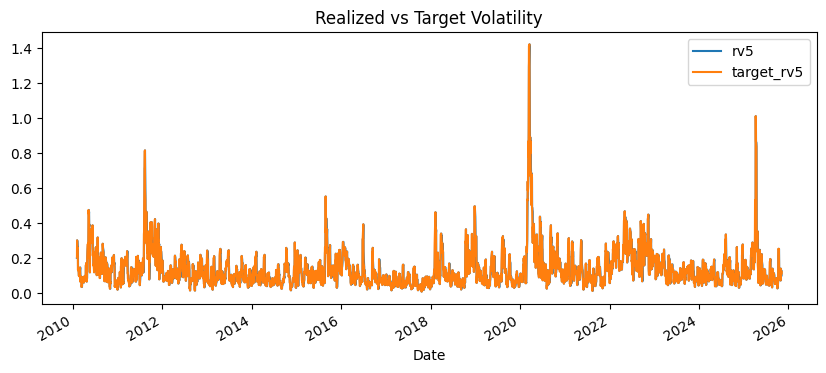

In [ ]:
# ===============================================================
# 📈 FINAL STABLE VERSION — S&P500 VOLATILITY DATA PREPARATION
# Compatible with new yfinance (auto_adjust=True default)
# ===============================================================
!pip -q install yfinance pandas numpy scikit-learn matplotlib

import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

# -----------------------------
# 1. Download all data in one call
# -----------------------------
tickers = ["SPY", "^VIX", "^VVIX", "^TNX"]
raw = yf.download(tickers, start="2010-01-01", progress=False)

# yfinance now gives a MultiIndex (Level 0 = field, Level 1 = ticker)
# e.g. ('Close', 'SPY'), ('Close', '^VIX'), etc.
if isinstance(raw.columns, pd.MultiIndex):
    # flatten
    raw.columns = [f"{col[0]}_{col[1].replace('^','')}" for col in raw.columns]
else:
    raw.columns = [col for col in raw.columns]

# Rename to simpler names
df = raw.rename(columns={
    "Close_SPY": "Close",
    "Open_SPY": "Open",
    "High_SPY": "High",
    "Low_SPY": "Low",
    "Volume_SPY": "Volume",
    "Close_VIX": "VIX",
    "Close_VVIX": "VVIX",
    "Close_TNX": "US10Y"
}).dropna()

print("Columns:", df.columns.tolist())
print(df.head())

# -----------------------------
# 2. Compute returns & realized volatility
# -----------------------------
# Adjusted Close no longer exists (auto-adjust done), so use Close directly
df["ret"] = np.log(df["Close"]).diff()

# Rolling realized vols (annualized)
df["rv5"]  = df["ret"].rolling(5).std()  * np.sqrt(252)
df["rv20"] = df["ret"].rolling(20).std() * np.sqrt(252)

# Future target vol (next 5 days)
df["target_rv5"]    = df["ret"].shift(-1).rolling(5).std() * np.sqrt(252)
df["log_rv_target"] = np.log(df["target_rv5"])

# -----------------------------
# 3. Feature engineering
# -----------------------------
df["ret_1"] = df["ret"]
df["ret_5"] = df["ret"].rolling(5).sum()
df["ret_20"] = df["ret"].rolling(20).sum()
df["abs_ret"] = df["ret"].abs()
df["range"] = (df["High"] - df["Low"]) / df["Open"]
df["rv_ratio"] = df["rv5"] / df["rv20"]
df["vix_slope"] = df["VIX"].rolling(5).mean() - df["VIX"].rolling(20).mean()
df["vix_change"] = df["VIX"].pct_change(5)
df["vvix_change"] = df["VVIX"].pct_change(5)
df["yield_change"] = df["US10Y"].diff(5)

df = df.dropna()

# -----------------------------
# 4. Volatility regimes
# -----------------------------
p33, p67 = df["log_rv_target"].quantile([0.33, 0.67])
df["regime"] = np.select(
    [df["log_rv_target"] < p33,
     df["log_rv_target"] < p67],
    [0, 1],
    default=2
)

# -----------------------------
# 5. Feature selection & splits
# -----------------------------
features = [
    "ret_1","ret_5","ret_20","abs_ret","range",
    "rv5","rv20","rv_ratio",
    "VIX","VVIX","vix_slope","vix_change","vvix_change",
    "US10Y","yield_change"
]
input_dim = 15  # number of input features used for training

X = df[features]
y_reg = df["log_rv_target"]
y_clf = df["regime"].astype(int)

split1, split2 = int(len(df)*0.7), int(len(df)*0.85)
X_train, X_val, X_test = X.iloc[:split1], X.iloc[split1:split2], X.iloc[split2:]
y_reg_train, y_reg_val, y_reg_test = y_reg.iloc[:split1], y_reg.iloc[split1:split2], y_reg.iloc[split2:]
y_clf_train, y_clf_val, y_clf_test = y_clf.iloc[:split1], y_clf.iloc[split1:split2], y_clf.iloc[split2:]

print(f"\nTrain/Val/Test sizes: {len(X_train)}, {len(X_val)}, {len(X_test)}")
print("Regime distribution (train):", y_clf_train.value_counts(normalize=True).round(3).to_dict())

# -----------------------------
# 6. Sanity plot
# -----------------------------
df[["rv5","target_rv5"]].plot(title="Realized vs Target Volatility", figsize=(10,4))
plt.show()

#### **Overview**
After preparing and splitting the dataset, this step standardizes the input features and converts all data into PyTorch tensors for efficient training.

#### **Main steps**
1. **Feature scaling** — Apply `StandardScaler` (fit on the training set only) to ensure all features have zero mean and unit variance.  
2. **Tensor conversion** — Transform NumPy arrays into `torch.FloatTensor` and `torch.LongTensor` for numerical and categorical targets.  
3. **DataLoader setup** — Wrap tensors into `TensorDataset` and `DataLoader` objects to enable mini-batch training, validation, and testing.

#### **Result**
- Scaled input tensors (`X_train_t`, `X_val_t`, `X_test_t`)  
- Corresponding regression (`y_reg_*_t`) and classification (`y_clf_*_t`) targets  
- Ready-to-use `DataLoader` objects for each split

> 🧩 Ensures consistent preprocessing between classical and hybrid quantum models.

In [ ]:
# ===============================================================
# 🔧 FEATURE SCALING + TORCH DATASETS
# ===============================================================
!pip -q install torch scikit-learn

import torch
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader

# --- 1) Standardize features (fit only on training set) ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)

# --- 2) Convert to PyTorch tensors ---
X_train_t = torch.tensor(X_train_scaled, dtype=torch.float32)
y_reg_train_t = torch.tensor(y_reg_train.values, dtype=torch.float32).unsqueeze(1)
y_clf_train_t = torch.tensor(y_clf_train.values, dtype=torch.long)

X_val_t = torch.tensor(X_val_scaled, dtype=torch.float32)
y_reg_val_t = torch.tensor(y_reg_val.values, dtype=torch.float32).unsqueeze(1)
y_clf_val_t = torch.tensor(y_clf_val.values, dtype=torch.long)

X_test_t = torch.tensor(X_test_scaled, dtype=torch.float32)
y_reg_test_t = torch.tensor(y_reg_test.values, dtype=torch.float32).unsqueeze(1)
y_clf_test_t = torch.tensor(y_clf_test.values, dtype=torch.long)

# --- 3) Create TensorDatasets & DataLoaders ---
BATCH_SIZE = 64

train_ds = TensorDataset(X_train_t, y_reg_train_t, y_clf_train_t)
val_ds   = TensorDataset(X_val_t,   y_reg_val_t,   y_clf_val_t)
test_ds  = TensorDataset(X_test_t,  y_reg_test_t,  y_clf_test_t)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE)

print("Tensors ready:")
print(f"Train loader batches: {len(train_loader)}")
print("Input dimension:", X_train_t.shape[1])
print("Example X batch:", next(iter(train_loader))[0].shape)

# ===============================================================
# ⚙️ REGRESSION TARGET SCALING HELPERS (restore stable training)
# ===============================================================
import torch

# Collect all training regression targets
y_train_vals = []
for _, y_regb, _ in train_loader:
    y_train_vals.append(y_regb.view(-1))
y_train_vals = torch.cat(y_train_vals).float()
y_min, y_max = y_train_vals.min().item(), y_train_vals.max().item()

# Avoid saturation of expvals
SCALE_MARGIN = 0.95

def scale_reg(y):
    """Scale regression targets to [-SCALE_MARGIN, SCALE_MARGIN]."""
    y = (y - y_min) / (y_max - y_min + 1e-8)  # normalize 0–1
    y = y * 2 - 1                             # shift to −1..1
    return torch.clamp(SCALE_MARGIN * y, -SCALE_MARGIN, SCALE_MARGIN)

def unscale_reg(y_scaled):
    """Invert scaling back to original value range."""
    y = torch.clamp(y_scaled, -SCALE_MARGIN, SCALE_MARGIN) / SCALE_MARGIN
    y = (y + 1) / 2
    return y * (y_max - y_min) + y_min

Tensors ready:
Train loader batches: 44
Input dimension: 15
Example X batch: torch.Size([64, 15])


#### **Overview**
This section defines the reusable training and evaluation routines used for both classical and hybrid quantum models.  
It introduces early stopping, automatic loss logging, and consistent metric collection for fair model comparison.

#### **Main steps**
1. **Training loop (`train_with_earlystop`)** —  
   Implements epoch-based training with combined loss (MSE + λ·CE), gradient clipping, and early stopping.  
   Records both training and validation loss histories for later visualization.

2. **Evaluation function (`evaluate_model`)** —  
   Runs inference on the test set, computes regression MSE and classification metrics (accuracy, F1-macro, recall per regime),  
   and returns normalized confusion matrices for side-by-side model assessment.

#### **Result**
- Early-stopped, fully trained models  
- Logged training/validation histories (`train_hist`, `val_hist`)  
- Structured evaluation outputs: accuracy, F1, recall, MSE, and confusion matrix  

> 📊 Enables reproducible, quantitative comparison between the **Classical MLP** and **Hybrid 8Q** architectures.

In [ ]:
# ===============================================================
# ⚙️ Install PennyLane (for Quantum Hybrid Models)
# ===============================================================
!pip install "pennylane-lightning>=0.38"

# ===============================================================
# 🧠 MODEL DEFINITIONS — Classical MLP & Hybrid 8Q
# ===============================================================
import torch
import torch.nn as nn
import pennylane as qml


# ===============================================================
# Classical baseline (mirrors Hybrid8Q exactly, no quantum)
# ===============================================================
class ClassicalMLP(nn.Module):
    def __init__(self, input_dim, n_qubits=8):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 48),
            nn.ReLU(),
            nn.Linear(48, n_qubits),
        )

        self.classical_block = nn.Sequential(
            nn.Linear(n_qubits, n_qubits),
            nn.ReLU(),
        )

        self.mid_norm = nn.LayerNorm(n_qubits)
        self.post = nn.Sequential(
            nn.Linear(n_qubits, 16),
            nn.ReLU(),
            nn.LayerNorm(16),
            nn.Dropout(0.15),
        )
        self.clf_head = nn.Linear(16, 3)
        self.to("cpu")

    def forward(self, x):
        # Symmetric scaling and noise
        z = 0.55 * torch.tanh(self.encoder(x))
        z = z + 0.015 * torch.randn_like(z)

        h_mid = self.classical_block(z)
        h = self.mid_norm(h_mid + z)   # normalize after residual
        h = self.post(h)
        return self.clf_head(h)


# ===============================================================
# Quantum block (v2) — Improved expressivity & gradient flow
# ===============================================================
class QuantumBlock(nn.Module):
    def __init__(self, n_qubits=8, layers=4, input_scale=1.8):
        super().__init__()
        self.n_qubits = n_qubits
        self.layers = layers
        self.input_scale = input_scale
        self.dev = qml.device("default.qubit", wires=n_qubits)

        @qml.qnode(self.dev, interface="torch", diff_method="best")
        def qnode(inputs, weights):
            # --- Improved input scaling & stochastic regularization ---
            x = self.input_scale * torch.tanh(inputs)
            x = x + 0.01 * torch.randn_like(x)  # mild dropout-style noise

            # --- Encoding & variational block ---
            qml.AngleEmbedding(x, wires=range(n_qubits), rotation="X")
            qml.StronglyEntanglingLayers(weights, wires=range(n_qubits))
            #qml.BasicEntanglerLayers(weights, wires=range(n_qubits))

            # --- Expectation value readout ---
            return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

        weight_shapes = {"weights": (layers, n_qubits, 3)}
        #weight_shapes = {"weights": (layers, n_qubits)}   # for BasicEntangler
        self.layer = qml.qnn.TorchLayer(qnode, weight_shapes)

        # --- Custom initialization ---
        with torch.no_grad():
            for p in self.layer.parameters():
                # Initialize around a small non-zero mean
                p.copy_(0.05 * torch.randn_like(p) + 0.02 * torch.sign(torch.randn_like(p)))

    def forward(self, x):
        return self.layer(x)


# ===============================================================
# Hybrid 8Q model (Quantum + Classical)
# ===============================================================
class Hybrid8Q(nn.Module):
    def __init__(self, input_dim, n_qubits=8):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 48),
            nn.ReLU(),
            nn.Linear(48, n_qubits),
        )

        self.quantum = QuantumBlock(n_qubits=n_qubits, layers=9)
        self.mid_norm = nn.LayerNorm(n_qubits)
        self.post = nn.Sequential(
            nn.Linear(n_qubits, 16),
            nn.ReLU(),
            nn.LayerNorm(16),
            nn.Dropout(0.15),
        )
        self.clf_head = nn.Linear(16, 3)
        self.to("cpu")

    def forward(self, x):
        # Symmetric scaling & noise
        z = 0.55 * torch.tanh(self.encoder(x))
        z = z + 0.015 * torch.randn_like(z)

        # Quantum block + residual + normalization
        q = self.quantum(z)
        h = self.mid_norm(q + z)
        h = self.post(h)
        return self.clf_head(h)



In [ ]:
# ===============================================================
# 🧩 Training & Evaluation — Universal (Classical or Hybrid)
# ===============================================================
import torch, numpy as np
from sklearn.metrics import accuracy_score, f1_score, recall_score, confusion_matrix
import torch.nn.functional as F

def train_with_earlystop(model, name, lr=7e-4, max_epochs=60, patience=15):
    is_hybrid = isinstance(model, Hybrid8Q)

    # Device: Hybrid on CPU, Classical on GPU if available
    if is_hybrid:
        model_device = torch.device("cpu")
    else:
        model_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model.to(model_device)

    # Optimizer + Cosine scheduler (identical for both)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_epochs)

    # === NEW: Class-weighted loss ===
    criterion = nn.CrossEntropyLoss(weight=torch.tensor([1.0, 1.0, 1.3], device=model_device))

    early = EarlyStopper(patience=patience, mode="min")
    train_hist, val_hist = [], []


    for epoch in range(1, max_epochs + 1):
        model.train()
        total = 0.0
        for Xb, _, y_clfb in train_loader:
            Xb = Xb.to(model_device)
            y_clfb = y_clfb.to(model_device)

            optimizer.zero_grad()
            logits = model(Xb)
            loss = F.cross_entropy(logits, y_clfb)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            total += loss.item()

        train_loss = total / len(train_loader)

        # Validation
        model.eval()
        val_total = 0.0
        with torch.no_grad():
            for Xv, _, y_clfv in val_loader:
                Xv = Xv.to(model_device)
                y_clfv = y_clfv.to(model_device)
                preds = model(Xv)
                val_total += F.cross_entropy(preds, y_clfv).item()
        val_loss = val_total / len(val_loader)

        # Log + Scheduler step
        train_hist.append(train_loss)
        val_hist.append(val_loss)
        scheduler.step()

        current_lr = scheduler.get_last_lr()[0]
        print(f"{name} Ep{epoch:03d} | Train {train_loss:.3f} | Val {val_loss:.3f} | LR {current_lr:.5f}")


        if early.step(val_loss, model, epoch):
            print(f"Early stop at epoch {epoch} | Best at {early.best_epoch}")
            break

    early.restore(model)
    return model, {"train": train_hist, "val": val_hist}


def evaluate_model(model, name):
    is_hybrid = isinstance(model, Hybrid8Q)
    model.eval()
    model_device = torch.device("cpu") if is_hybrid else torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(model_device)

    y_true, y_pred = [], []

    with torch.no_grad():
        for Xb, _, y_clfb in test_loader:
            Xb = Xb.to(model_device)
            y_clfb = y_clfb.to(model_device)
            preds = torch.softmax(model(Xb), dim=1).argmax(1)
            y_true.append(y_clfb.cpu().numpy())
            y_pred.append(preds.cpu().numpy())

    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)

    cm = confusion_matrix(y_true, y_pred, normalize="true")
    acc = accuracy_score(y_true, y_pred)
    f1m = f1_score(y_true, y_pred, average="macro")
    recL = recall_score(y_true, y_pred, labels=[0], average="macro")
    recH = recall_score(y_true, y_pred, labels=[2], average="macro")

    print(f"\n🔹 {name} | Acc {acc*100:.1f}% | F1-macro {f1m:.3f} | "
          f"Low recall {recL:.2f} | High recall {recH:.2f}")

    return {"cm": cm, "metrics": [acc, f1m, recL, recH]}


#### **Overview**
This final section executes the full experiment, training and evaluating both the **Classical MLP** and the **Hybrid 8Q** models under identical conditions.  
Each model is trained with early stopping and logged losses, then tested on unseen data to assess predictive performance.

#### **Main steps**
1. **Model initialization** — Create instances of the classical and hybrid architectures.  
2. **Training phase** — Run `train_with_earlystop()` for both models using the same learning rate, patience, and loss weights.  
3. **Evaluation phase** — Use `evaluate_model()` to compute accuracy, F1, recall per volatility regime, and regression MSE.  
4. **Result extraction** — Store confusion matrices and metric lists for later visualization and summary comparison.

#### **Result**
- Fully trained **Classical MLP** and **Hybrid 8Q** models  
- Training histories (`history_classical`, `history_hybrid`)  
- Evaluation results (`res_classical`, `res_hybrid`) ready for tabular and graphical comparison  

> 🧩 Enables a transparent, side-by-side performance comparison between classical and quantum-enhanced learning approaches on the same volatility dataset.

Running on: cpu
Classical MLP Ep001 | Train 1.066 | Val 1.023 | LR 0.00030
Classical MLP Ep002 | Train 0.887 | Val 0.878 | LR 0.00030
Classical MLP Ep003 | Train 0.793 | Val 0.774 | LR 0.00030
Classical MLP Ep004 | Train 0.731 | Val 0.692 | LR 0.00030
Classical MLP Ep005 | Train 0.680 | Val 0.638 | LR 0.00029
Classical MLP Ep006 | Train 0.639 | Val 0.606 | LR 0.00029
Classical MLP Ep007 | Train 0.619 | Val 0.589 | LR 0.00029
Classical MLP Ep008 | Train 0.604 | Val 0.570 | LR 0.00029
Classical MLP Ep009 | Train 0.590 | Val 0.569 | LR 0.00028
Classical MLP Ep010 | Train 0.578 | Val 0.550 | LR 0.00028
Classical MLP Ep011 | Train 0.574 | Val 0.547 | LR 0.00028
Classical MLP Ep012 | Train 0.561 | Val 0.553 | LR 0.00027
Classical MLP Ep013 | Train 0.556 | Val 0.540 | LR 0.00027
Classical MLP Ep014 | Train 0.553 | Val 0.542 | LR 0.00026
Classical MLP Ep015 | Train 0.544 | Val 0.544 | LR 0.00026
Classical MLP Ep016 | Train 0.548 | Val 0.540 | LR 0.00025
Classical MLP Ep017 | Train 0.543 | Val 

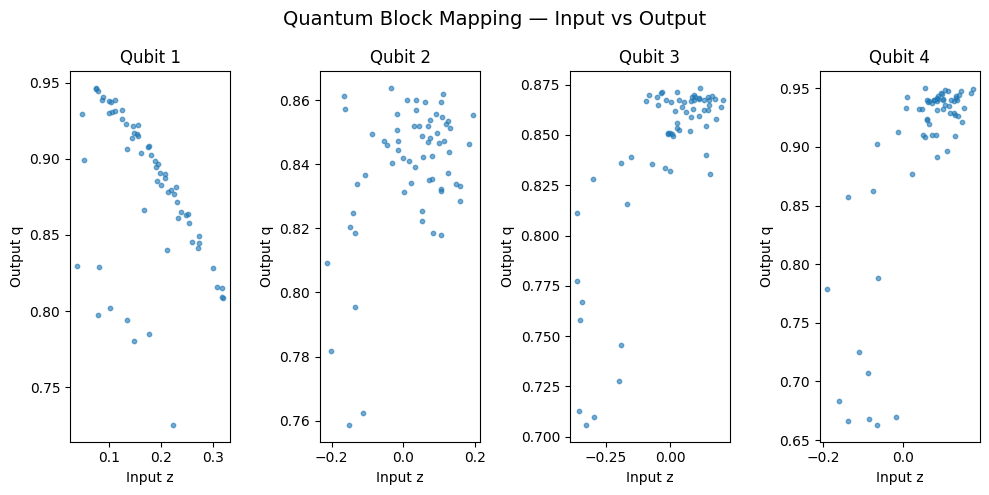

In [ ]:
# ===============================================================
# ⚙️ DEVICE SETUP
# ===============================================================
import torch
import pennylane as qml

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on:", device)

seed=111
torch.manual_seed(seed)
qml.numpy.random.seed(seed)
np.random.seed(seed)


# ===============================================================
# ⏹️ EARLY STOPPING HELPER
# ===============================================================
class EarlyStopper:
    def __init__(self, patience=8, mode="min"):
        self.patience = patience
        self.mode = mode
        self.best = float("inf") if mode == "min" else -float("inf")
        self.count = 0
        self.best_state = None
        self.best_epoch = 0

    def step(self, metric, model, epoch):
        improved = (metric < self.best) if self.mode == "min" else (metric > self.best)
        if improved:
            self.best = metric
            self.count = 0
            self.best_epoch = epoch
            self.best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
        else:
            self.count += 1
        return self.count >= self.patience

    def restore(self, model):
        if self.best_state is not None:
            model.load_state_dict(self.best_state)


# ===============================================================
# 🧠 TRAIN & EVALUATE — CLASSICAL & HYBRID MODELS
# ===============================================================

mlp_model = ClassicalMLP(input_dim)
hybrid_model = Hybrid8Q(input_dim)

# training
mlp_trained, hist_classical = train_with_earlystop(
    mlp_model,
    name="Classical MLP",
    lr=3e-4,
    patience=20,
    max_epochs=60
)

hybrid_trained, hist_hybrid = train_with_earlystop(
    hybrid_model,
    name="Hybrid 8Q",
    lr=3e-4,
    patience=25,
    max_epochs=70
)

# evaluation
res_classical = evaluate_model(mlp_trained, "Classical MLP")
res_hybrid = evaluate_model(hybrid_trained, "Hybrid 8Q")

# unpack for summary/plotting
res_classical_cm = res_classical["cm"]
res_hybrid_cm = res_hybrid["cm"]
res_classical_metrics = res_classical["metrics"]
res_hybrid_metrics = res_hybrid["metrics"]

print("\n✅ Training completed and models evaluated.")


# ===============================================================
# 🧭 Quantum Block Diagnostic — "How quantum is it?"
# ===============================================================
import torch
import matplotlib.pyplot as plt
import numpy as np

# use some validation or test data
X_sample, _, _ = next(iter(val_loader))
X_sample = X_sample[:256]  # small subset for clarity
X_sample = X_sample.to("cpu")

# --- Classical baseline: output after encoder ---
with torch.no_grad():
    z_classical = 0.5 * torch.tanh(mlp_trained.encoder(X_sample))
    z_hybrid_in = 0.5 * torch.tanh(hybrid_trained.encoder(X_sample))
    q_hybrid_out = hybrid_trained.quantum(z_hybrid_in)

# --- Quantify deviation ---
diff_mean = (q_hybrid_out - z_hybrid_in).abs().mean().item()

# 🔧 Detach before converting to NumPy
z_hybrid_in_np = z_hybrid_in.detach().cpu().numpy()
q_hybrid_out_np = q_hybrid_out.detach().cpu().numpy()

corr_input = np.corrcoef(z_hybrid_in_np, rowvar=False)
corr_output = np.corrcoef(q_hybrid_out_np, rowvar=False)
corr_shift = np.mean(np.abs(corr_output - corr_input))

print(f"🔹 Mean |q - z| difference: {diff_mean:.4f}")
print(f"🔹 Mean correlation structure change: {corr_shift:.4f}")

# --- Scatter plot: input vs output per qubit ---
plt.figure(figsize=(10, 5))
for i in range(min(4, z_hybrid_in.shape[1])):  # show first few qubits
    plt.subplot(1, 4, i + 1)
    plt.scatter(
        z_hybrid_in[:, i].cpu(),
        q_hybrid_out[:, i].cpu(),
        s=10, alpha=0.6
    )
    plt.title(f"Qubit {i+1}")
    plt.xlabel("Input z")
    plt.ylabel("Output q")
plt.suptitle("Quantum Block Mapping — Input vs Output", fontsize=14)
plt.tight_layout()
plt.show()



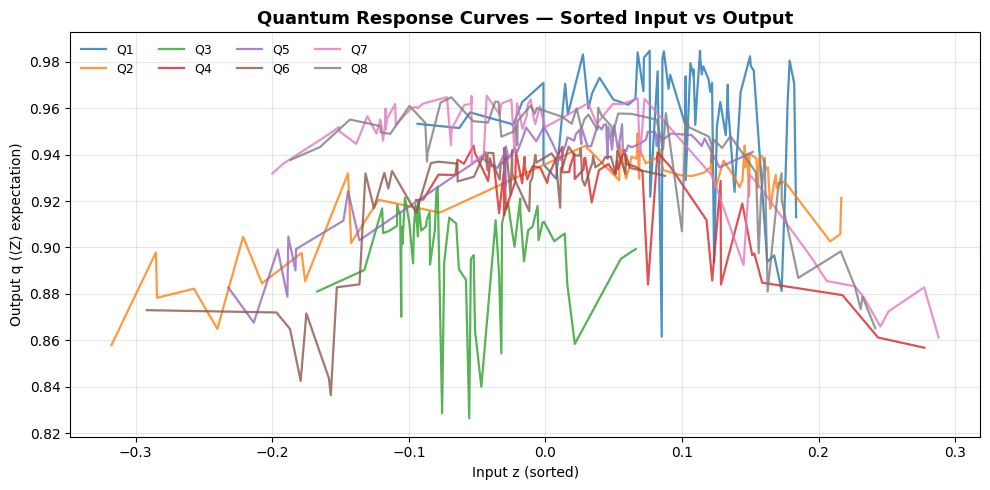

In [ ]:
import matplotlib.pyplot as plt
import torch
import numpy as np

# Assuming you already have:
# z_hybrid_in, q_hybrid_out from your diagnostic cell

# Convert to NumPy
z = z_hybrid_in.detach().cpu().numpy()
q = q_hybrid_out.detach().cpu().numpy()

n_qubits = min(8, z.shape[1])  # just to limit to first few

plt.figure(figsize=(10, 5))
for i in range(n_qubits):
    # sort inputs to get smooth curve
    sort_idx = np.argsort(z[:, i])
    plt.plot(
        z[sort_idx, i],
        q[sort_idx, i],
        label=f"Q{i+1}",
        linewidth=1.6,
        alpha=0.8
    )

plt.title("Quantum Response Curves — Sorted Input vs Output", fontsize=13, weight="bold")
plt.xlabel("Input z (sorted)")
plt.ylabel("Output q (⟨Z⟩ expectation)")
plt.grid(alpha=0.3)
plt.legend(frameon=False, ncol=4, fontsize=9)
plt.tight_layout()
plt.show()

In [ ]:
corr_in = np.corrcoef(z_hybrid_in.detach().cpu().numpy(), rowvar=False)
corr_out = np.corrcoef(q_hybrid_out.detach().cpu().numpy(), rowvar=False)
entanglement_strength = np.mean(np.abs(corr_out - corr_in))
print(f"Estimated entanglement strength ≈ {entanglement_strength:.3f}")

Estimated entanglement strength ≈ 0.860


#### **Overview**
This final section visualizes and compares the performance of the **Classical MLP** and **Hybrid 8Q** models.  
It highlights training dynamics, classification behaviour across volatility regimes, and quantitative evaluation metrics.

#### **Main steps**
1. **Training curves** — Plot training and validation losses for both models to illustrate convergence speed and stability.  
2. **Confusion matrices** — Display normalized regime predictions (*Low*, *Medium*, *High*) side by side to show classification accuracy patterns.  
3. **Performance summary** — Compile key metrics (Accuracy, F1-macro, Recall per regime, Test MSE) into a concise comparison table.

#### **Result**
A clear, data-driven overview of model behaviour and accuracy:
- Visualization of learning progress  
- Regime-level comparison between classical and quantum models  
- Summary table supporting an objective performance assessment

> 📈 Provides the final visual and numerical evidence of how the **hybrid quantum approach** performs relative to its classical baseline.

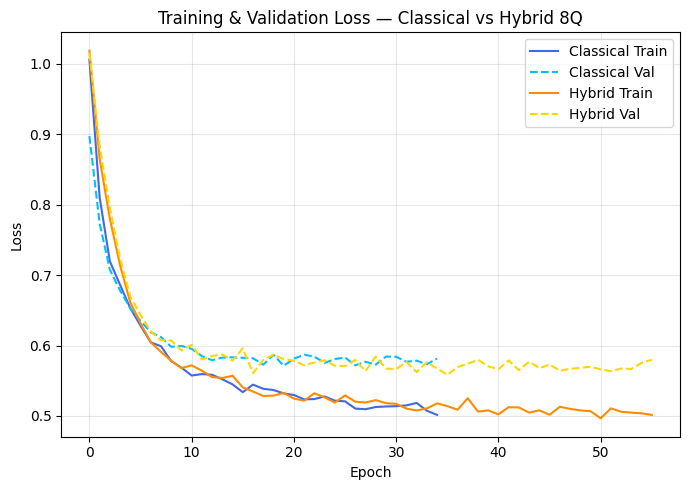

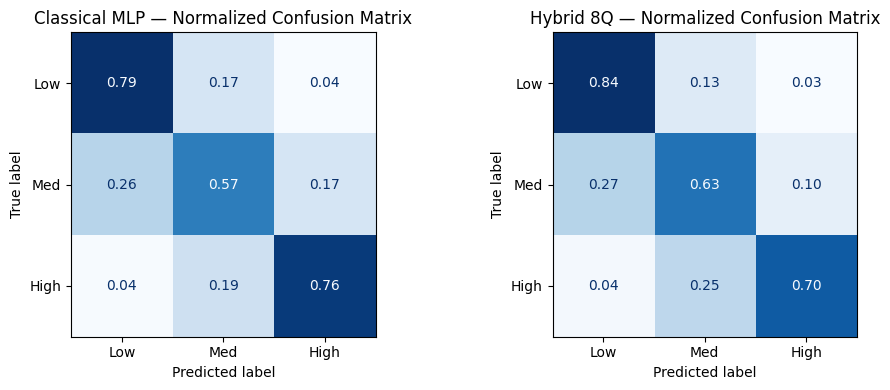

,Accuracy,F1-macro,Low Recall,High Recall
Classical MLP,0.682,0.687,0.794,0.763
Hybrid 8Q,0.710,0.714,0.839,0.704


In [ ]:
# ===============================================================
# 📊 FINAL COMPARISON: Classical MLP vs Hybrid 8Q
# - Shows loss curves, confusion matrices, and summary table
# ===============================================================
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import ConfusionMatrixDisplay

# --- 1️⃣ Plot training curves ---
plt.figure(figsize=(7, 5))
plt.plot(hist_classical["train"], label="Classical Train", color="royalblue")
plt.plot(hist_classical["val"], label="Classical Val", color="deepskyblue", linestyle="--")
plt.plot(hist_hybrid["train"], label="Hybrid Train", color="darkorange")
plt.plot(hist_hybrid["val"], label="Hybrid Val", color="gold", linestyle="--")
plt.title("Training & Validation Loss — Classical vs Hybrid 8Q")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# --- 2️⃣ Confusion matrices side-by-side ---
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
for ax, (title, data) in zip(
    axes,
    [("Classical MLP", res_classical_cm), ("Hybrid 8Q", res_hybrid_cm)]
):
    disp = ConfusionMatrixDisplay(data, display_labels=["Low", "Med", "High"])
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    ax.set_title(f"{title} — Normalized Confusion Matrix")
plt.tight_layout()
plt.show()

# --- 3️⃣ Summary Table ---
# Ensure both results have the same metric length
while len(res_classical["metrics"]) < 4:
    res_classical["metrics"].append(None)
while len(res_hybrid["metrics"]) < 4:
    res_hybrid["metrics"].append(None)

cols = ["Accuracy", "F1-macro", "Low Recall", "High Recall", "Test MSE"]
n_cols = len(res_classical["metrics"])
summary = pd.DataFrame(
    [res_classical["metrics"], res_hybrid["metrics"]],
    index=["Classical MLP", "Hybrid 8Q"],
    columns=cols[:n_cols]
)

display(summary.style.format(lambda x: f"{x:.3f}" if pd.notna(x) else "—")
        .set_caption("📈 Model Performance Summary"))

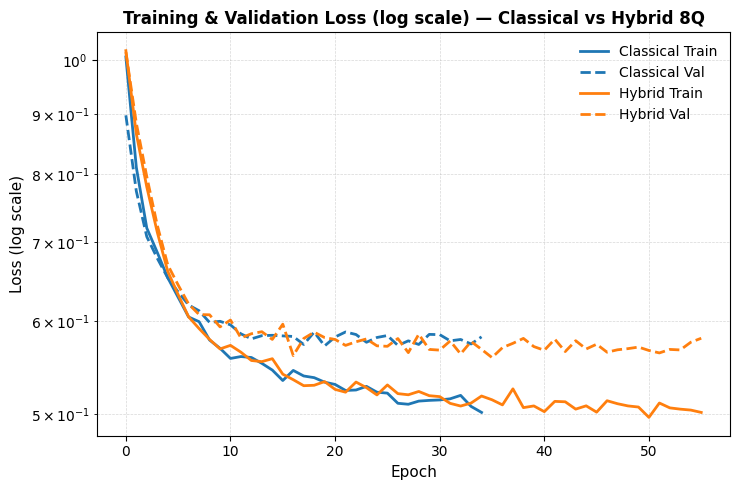

In [ ]:
# ===============================================================
# 📊 Improved Training Curves — Classical vs Hybrid 8Q
# - log scale for better readability
# - cleaner layout & labels
# ===============================================================
import matplotlib.pyplot as plt

plt.figure(figsize=(7.5, 5))

# Plot with solid lines for train, dashed for val
plt.plot(hist_classical["train"], label="Classical Train", color="#1f77b4", linewidth=2)
plt.plot(hist_classical["val"], label="Classical Val", color="#1f77b4", linestyle="--", linewidth=2)
plt.plot(hist_hybrid["train"], label="Hybrid Train", color="#ff7f0e", linewidth=2)
plt.plot(hist_hybrid["val"], label="Hybrid Val", color="#ff7f0e", linestyle="--", linewidth=2)

# Use logarithmic scale for Y axis
plt.yscale("log")

plt.title("Training & Validation Loss (log scale) — Classical vs Hybrid 8Q", fontsize=12, weight="bold")
plt.xlabel("Epoch", fontsize=11)
plt.ylabel("Loss (log scale)", fontsize=11)
plt.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.5)
plt.legend(frameon=False, fontsize=10)
plt.tight_layout()
plt.show()

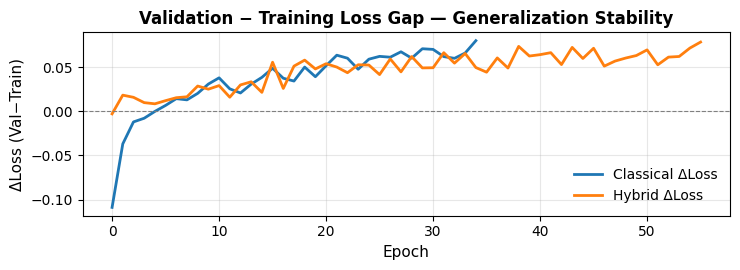

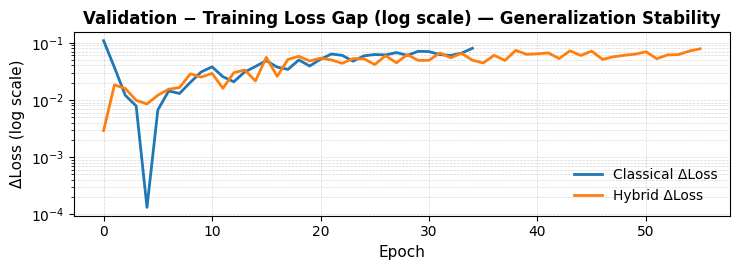

In [ ]:
# ===============================================================
# 📉 Validation–Training Loss Gap — Generalization Stability
# - Shows raw and log-scale differences
# ===============================================================
import numpy as np
import matplotlib.pyplot as plt

# --- 1️⃣ Absolute difference (Val − Train) ---
plt.figure(figsize=(7.5, 2.8))
Δ_classical = np.array(hist_classical["val"]) - np.array(hist_classical["train"])
Δ_hybrid = np.array(hist_hybrid["val"]) - np.array(hist_hybrid["train"])

plt.plot(Δ_classical, label="Classical ΔLoss", color="#1f77b4", linewidth=2)
plt.plot(Δ_hybrid, label="Hybrid ΔLoss", color="#ff7f0e", linewidth=2)
plt.title("Validation − Training Loss Gap — Generalization Stability", fontsize=12, weight="bold")
plt.xlabel("Epoch", fontsize=11)
plt.ylabel("ΔLoss (Val−Train)", fontsize=11)
plt.axhline(0, color="gray", linestyle="--", linewidth=0.8)
plt.grid(alpha=0.3)
plt.legend(frameon=False, fontsize=10)
plt.tight_layout()
plt.show()

# --- 2️⃣ Log-scale version for small deltas ---
plt.figure(figsize=(7.5, 2.8))
Δ_classical = np.abs(np.array(hist_classical["val"]) - np.array(hist_classical["train"]))
Δ_hybrid = np.abs(np.array(hist_hybrid["val"]) - np.array(hist_hybrid["train"]))

plt.plot(Δ_classical, label="Classical ΔLoss", color="#1f77b4", linewidth=2)
plt.plot(Δ_hybrid, label="Hybrid ΔLoss", color="#ff7f0e", linewidth=2)
plt.yscale("log")
plt.title("Validation − Training Loss Gap (log scale) — Generalization Stability", fontsize=12, weight="bold")
plt.xlabel("Epoch", fontsize=11)
plt.ylabel("ΔLoss (log scale)", fontsize=11)
plt.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.5)
plt.legend(frameon=False, fontsize=10)
plt.tight_layout()
plt.show()

In [ ]:
# ===============================================================
# 🎯 Extract true and predicted labels — Classical vs Hybrid
# ===============================================================
import numpy as np
import torch

y_true, y_pred_classical, y_pred_hybrid = [], [], []

# --------------- Classical ----------------
mlp_trained.eval()
with torch.no_grad():
    for Xb, _, y_clfb in test_loader:
        Xb, y_clfb = Xb.to(device), y_clfb.to(device)
        logits = mlp_trained(Xb)
        preds = torch.softmax(logits, dim=1).argmax(1)
        y_true.append(y_clfb.cpu().numpy())
        y_pred_classical.append(preds.cpu().numpy())

# --------------- Hybrid ----------------
hybrid_trained.eval()
with torch.no_grad():
    for Xb, _, y_clfb in test_loader:
        Xb, y_clfb = Xb.to(device), y_clfb.to(device)
        logits = hybrid_trained(Xb)
        preds = torch.softmax(logits, dim=1).argmax(1)
        y_pred_hybrid.append(preds.cpu().numpy())

# --- Combine into single arrays ---
y_true = np.concatenate(y_true)
y_pred_classical = np.concatenate(y_pred_classical)
y_pred_hybrid = np.concatenate(y_pred_hybrid)

print(f"✅ Extracted predictions for {len(y_true)} test samples.")

✅ Extracted predictions for 594 test samples.


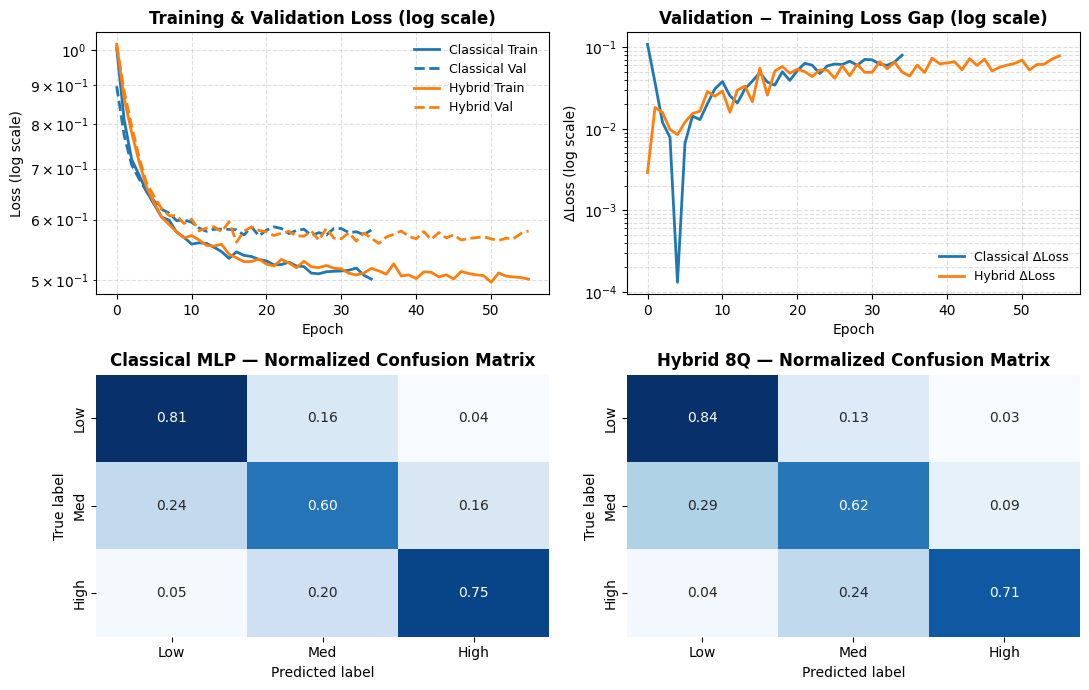

In [ ]:
# ============================================================
# 📊 Summary Dashboard — Classical vs Hybrid 8Q
# Combines training curves, ΔLoss, and confusion matrices
# ============================================================
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix

fig, axes = plt.subplots(2, 2, figsize=(11, 7))

# 1️⃣ TRAINING/VALIDATION LOSS (LOG SCALE)
axes[0, 0].plot(hist_classical["train"], label="Classical Train", color="#1f77b4", linewidth=2)
axes[0, 0].plot(hist_classical["val"], "--", label="Classical Val", color="#1f77b4", linewidth=2)
axes[0, 0].plot(hist_hybrid["train"], label="Hybrid Train", color="#ff7f0e", linewidth=2)
axes[0, 0].plot(hist_hybrid["val"], "--", label="Hybrid Val", color="#ff7f0e", linewidth=2)
axes[0, 0].set_yscale("log")
axes[0, 0].set_title("Training & Validation Loss (log scale)", fontsize=12, weight="bold")
axes[0, 0].set_xlabel("Epoch")
axes[0, 0].set_ylabel("Loss (log scale)")
axes[0, 0].grid(True, which="both", linestyle="--", alpha=0.4)
axes[0, 0].legend(frameon=False, fontsize=9)

# 2️⃣ ΔLOSS (VALIDATION - TRAINING, LOG SCALE)
Δ_classical = np.abs(np.array(hist_classical["val"]) - np.array(hist_classical["train"]))
Δ_hybrid = np.abs(np.array(hist_hybrid["val"]) - np.array(hist_hybrid["train"]))
axes[0, 1].plot(Δ_classical, label="Classical ΔLoss", color="#1f77b4", linewidth=2)
axes[0, 1].plot(Δ_hybrid, label="Hybrid ΔLoss", color="#ff7f0e", linewidth=2)
axes[0, 1].set_yscale("log")
axes[0, 1].set_title("Validation − Training Loss Gap (log scale)", fontsize=12, weight="bold")
axes[0, 1].set_xlabel("Epoch")
axes[0, 1].set_ylabel("ΔLoss (log scale)")
axes[0, 1].grid(True, which="both", linestyle="--", alpha=0.4)
axes[0, 1].legend(frameon=False, fontsize=9)

# 3️⃣ CONFUSION MATRIX — CLASSICAL
cm_c = confusion_matrix(y_true, y_pred_classical, normalize="true")
sns.heatmap(cm_c, annot=True, fmt=".2f", cmap="Blues", cbar=False,
            xticklabels=["Low", "Med", "High"], yticklabels=["Low", "Med", "High"], ax=axes[1, 0])
axes[1, 0].set_title("Classical MLP — Normalized Confusion Matrix", fontsize=12, weight="bold")
axes[1, 0].set_xlabel("Predicted label")
axes[1, 0].set_ylabel("True label")

# 4️⃣ CONFUSION MATRIX — HYBRID
cm_h = confusion_matrix(y_true, y_pred_hybrid, normalize="true")
sns.heatmap(cm_h, annot=True, fmt=".2f", cmap="Blues", cbar=False,
            xticklabels=["Low", "Med", "High"], yticklabels=["Low", "Med", "High"], ax=axes[1, 1])
axes[1, 1].set_title("Hybrid 8Q — Normalized Confusion Matrix", fontsize=12, weight="bold")
axes[1, 1].set_xlabel("Predicted label")
axes[1, 1].set_ylabel("True label")

plt.tight_layout()
plt.show()

#### **Optional experiment: Fully-quantum baseline (15 qubits)**
This section tests a *circuit-only* approach: the model consists purely of a 15-qubit variational quantum circuit without any classical post-processing layers.  
Inputs are embedded directly into the circuit, a parametrized ansatz is trained, and the predictions are read out **directly from expectation values**:

- **Regression signal** → `Z(0)` (scaled to match the target volatility range)
- **Classification logits** → `Z(1..3)` (three expvals, rescaled by a learnable temperature)

#### **Why this experiment?**
The previous models (Classical MLP and Hybrid 8Q) used a **quantum block as a feature generator** and then let classical layers learn the task.  
This experiment asks the harder question:  
> *Can a pure QNN, with no classical head, learn the same volatility task?*

#### **What to expect**
- Training is typically **less stable** than the hybrid version (more saturation, shallower gradients).
- Scaling of regression targets is required because expvals live in **[-1, 1]**.
- Performance will often be **below** the hybrid model — this cell mainly serves as a research / demo comparison, not the recommended production path.

> 🧪 If the loss does not decrease or accuracy stays flat, it’s usually due to vanishing gradients in the deeper PQC, not a bug in the data pipeline.

#### **Troubleshooting & Tips**

If training fails to progress (flat loss, random accuracy), the reasons are usually related to **vanishing gradients** and **limited signal expressivity**.  
Below are practical strategies to improve learnability:

1. **Reduce circuit size**  
   - Try **8–10 qubits** instead of 15 to keep the optimization landscape smoother.  
   - Smaller circuits typically have better gradient flow and fewer barren plateaus.

2. **Add a small classical readout layer**  
   - After the quantum expvals, pass them through a `Linear(15 → 8)` + `ReLU` block before the regression/classification heads.  
   - This hybrid head often stabilizes training without undermining the “quantum core.”

3. **Use local or layer-wise cost functions**  
   - Instead of global MSE + CE, train using **partial costs** (e.g., per-qubit or per-feature losses).  
   - Helps keep gradients alive in early layers.

4. **Experiment with initialization**  
   - Initialize circuit weights closer to zero (`0.001 * torch.randn(...)`) to start in a high-gradient region.  
   - Avoid large random weights that push rotations into saturation.

5. **Adjust λ (loss balance)**  
   - If classification dominates, the MSE term may vanish; test smaller λ values (e.g., 0.05–0.1).

> ⚛️ Fully quantum models are elegant but extremely sensitive to depth, qubit count, and initialization —  
> hybrid architectures remain the practical path for near-term, data-driven tasks.